# <font color="pink"> ***Projet Hiatini TEKOHUOTETUA & Aurélie JAMMES***</font>

## <font color="lightblue">***Part 1 </font> - Donald Trump Communication Analysis on Twitter***

---
####<font color="pink"> **I. Database preparation** </font>


In [ ]:
# for installing java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# for downloading hadoop for spark
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzipping hadoop for spark
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# setting environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

# installing spark on the current environment
!pip install -q findspark
import findspark
findspark.init()

# mount your google drive to be able to access files from your google drive ! 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**We really start the spark code below and create a SparkSession from pyspark sql for working with DataFrame. SparkSession for DataFrames plays the same role as SparkContext for RDDs.**

In [ ]:
import pyspark
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

In [ ]:
spark = pyspark.sql.SparkSession.builder.appName("Projet-Hiatini-Aurelie").getOrCreate()

---
#### <font color="pink">  **II.Extracting product reviews words** </font>

Four groups of words can be identified in these documents:

- Words that are likely to convey a favorable opinion (a list is provided in positive-words.txt)
- Negative words: expressions of what is likely disapproval (a list is provided in negative-words.txt)
- stop words: Probably meaningless words (a list is provided in stop-words.txt)
- neutral terms (also known as contextual words): expressions used in reviews that don't fall under the first three categories.

We will offer visuals that can assist in studying and assessing the most significant viewpoints that Trump expressed in each tweet.


In [ ]:
import pyspark
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

In [ ]:
rdd_tweets = sc.textFile('drive/MyDrive/Big data tools/Project/trump_tweets.txt')

rdd_tweets.take(5)

['Republicans and Democrats have both created our economic problems.;02/08/2011 18:07:48',
 'I was thrilled to be back in the Great city of Charlotte, North Carolina with thousands of hardworking American Patriots who love our Country, cherish our values, respect our laws, and always put AMERICA FIRST! Thank you for a wonderful evening!! #KAG2020 https://t.co/dNJZfRsl9y;03/03/2020 01:34:50',
 'RT @CBS_Herridge: READ: Letter to surveillance court obtained by CBS News questions where there will be further disciplinary action and cho…;17/01/2020 03:22:47',
 'The Unsolicited Mail In Ballot Scam is a major threat to our Democracy, &amp  the Democrats know it. Almost all recent elections using this system, even though much smaller &amp   with far fewer Ballots to count, have ended up being a disaster. Large numbers of missing Ballots &amp  Fraud!;12/09/2020 20:10:58',
 "RT @MZHemingway: Very friendly telling of events here about Comey's apparent leaking to compliant media. If you read those 

In [ ]:
# we define an utility function that can split each line into individual words by using multiple separators
# this function returns a list of individual words from the string parameter by applying the split 
# note that the result can contain empty strings

import re

def split_with_multiple_separator(string_value):
    return re.split('#|,| |\[|\]', string_value.strip())

# usage example:

split_with_multiple_separator(rdd_tweets.take(1)[0])

['Republicans',
 'and',
 'Democrats',
 'have',
 'both',
 'created',
 'our',
 'economic',
 'problems.;02/08/2011',
 '18:07:48']

In [ ]:
# compute an rdd with individual words (rdd_tweets_words) from the rdd_tweets by using the previous function
# rdd_tweets_words should not contain empty strings

rdd_tweets_words = rdd_tweets.flatMap(split_with_multiple_separator).filter(lambda word: word!='')

rdd_tweets_words.take(5)

['Republicans', 'and', 'Democrats', 'have', 'both']

In [ ]:
# initialize an rdd with key/value for counting each word in the file 

rdd_tweets_words_kv = rdd_tweets_words.map(lambda word: (word, 1))

rdd_tweets_words_kv.take(5)

[('Republicans', 1), ('and', 1), ('Democrats', 1), ('have', 1), ('both', 1)]

##### <font color="pink">  **II. a. Top positives and top negatives words used** </font>


> Before using the lists, they must be prepared. So we will prepare the list of positive words. The same process, adapted, will be applied to the list of negative words.



In [ ]:
# we read the positive words
rdd_positive_tweets = sc.textFile('drive/MyDrive/Big data tools/Project/positive-words.txt')

rdd_positive_tweets.take(5)

['a+', 'abound', 'abounds', 'abundance', 'abundant']

In [ ]:
# initialize an rdd with key/value for counting each positive word in the file 

rdd_positive_tweets_kv = rdd_positive_tweets.map(lambda word: (word, 1))

rdd_positive_tweets_kv.take(5)

[('a+', 1), ('abound', 1), ('abounds', 1), ('abundance', 1), ('abundant', 1)]

In [ ]:
# rdd_positive_tweets_product_kv RDD should contain positive tweets in the product review file

rdd_positive_tweets_product_kv = rdd_tweets_words_kv.join(rdd_positive_tweets_kv)

rdd_positive_tweets_product_kv.take(5)

[('thrilled', (1, 1)),
 ('thrilled', (1, 1)),
 ('thrilled', (1, 1)),
 ('thrilled', (1, 1)),
 ('thrilled', (1, 1))]

In [ ]:
# use the mapValues transformation to assign a default count of 1 for each positive word

rdd_positive_tweets_product_kv = rdd_positive_tweets_product_kv.mapValues(lambda tuple: 1)

rdd_positive_tweets_product_kv.take(5)

[('thrilled', 1),
 ('thrilled', 1),
 ('thrilled', 1),
 ('thrilled', 1),
 ('thrilled', 1)]

In [ ]:
# rdd_positive_tweets_product_count_kv should contain the number of occurences (count) of each positive word in product reviews
rdd_positive_tweets_product_count_kv = rdd_positive_tweets_product_kv.reduceByKey(lambda x,y : x+y)


rdd_positive_tweets_product_count_kv.take(5)

[('thrilled', 44),
 ('wonderful', 442),
 ('right', 666),
 ('sustainable', 1),
 ('best', 884)]

In [ ]:
# rdd_positive_tweets_product_count_kv_ordered should contain the previous RDD in descending order based on the count

rdd_positive_tweets_product_count_kv_ordered = rdd_positive_tweets_product_count_kv.sortBy(lambda tuple: tuple[1], ascending=False)

list_top_positives_opinion = rdd_positive_tweets_product_count_kv_ordered.take(25)

list_top_positives_opinion

[('great', 3964),
 ('like', 1756),
 ('good', 1243),
 ('best', 884),
 ('love', 839),
 ('work', 727),
 ('right', 666),
 ('better', 647),
 ('win', 631),
 ('support', 500),
 ('well', 457),
 ('wonderful', 442),
 ('strong', 441),
 ('honor', 384),
 ('amazing', 365),
 ('important', 356),
 ('thank', 353),
 ('nice', 352),
 ('beautiful', 329),
 ('incredible', 306),
 ('greatest', 283),
 ('protect', 281),
 ('tough', 278),
 ('ready', 278),
 ('proud', 278)]


> Extracting top negatives  tweets

In [ ]:
# we read the negatives tweets
rdd_negatives_tweets = sc.textFile('drive/MyDrive/Big data tools/Project/negative-words.txt')

rdd_negatives_tweets.take(5)

['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable']

In [ ]:
# initialize an rdd with key/value for counting each negative word in the file 

rdd_negative_tweets_kv = rdd_negatives_tweets.map(lambda word: (word, 1))

rdd_negative_tweets_kv.take(5)

[('2-faced', 1),
 ('2-faces', 1),
 ('abnormal', 1),
 ('abolish', 1),
 ('abominable', 1)]

In [ ]:
# rdd_negative_tweets_product_kv RDD should contain negative words in the product review file

rdd_negative_tweets_product_kv = rdd_tweets_words_kv.join(rdd_negative_tweets_kv)

rdd_negative_tweets_product_kv.take(5)

[('threat', (1, 1)),
 ('threat', (1, 1)),
 ('threat', (1, 1)),
 ('threat', (1, 1)),
 ('threat', (1, 1))]

In [ ]:
# use the mapValues transformation to assign a default count of 1 for each negative word

rdd_negative_tweets_product_kv = rdd_negative_tweets_product_kv.mapValues(lambda tuple:1)

rdd_negative_tweets_product_kv.take(5)

[('threat', 1), ('threat', 1), ('threat', 1), ('threat', 1), ('threat', 1)]

In [ ]:
# rdd_negative_tweets_product_count_kv should contain the number of occurences (count) of each negative word in product reviews

rdd_negative_tweets_product_count_kv = rdd_negative_tweets_product_kv.reduceByKey(lambda x,y: x+y)

rdd_negative_tweets_product_count_kv.take(5)

[('threat', 68),
 ('dishonest', 148),
 ('lost', 306),
 ('killed', 154),
 ('risk', 57)]

In [ ]:
# rdd_negative_tweets_product_count_kv_ordered should contain the previous RDD in descending order based on the count

rdd_negative_tweets_product_count_kv_ordered = rdd_negative_tweets_product_count_kv.sortBy(lambda tuple: tuple[1], ascending=False)

list_top_negatives_opinion = rdd_negative_tweets_product_count_kv_ordered.take(25)

list_top_negatives_opinion

[('bad', 718),
 ('hard', 616),
 ('lost', 306),
 ('illegal', 300),
 ('terrible', 276),
 ('attack', 240),
 ('crime', 238),
 ('failed', 222),
 ('worst', 217),
 ('wrong', 213),
 ('corrupt', 203),
 ('phony', 191),
 ('badly', 188),
 ('weak', 179),
 ('failing', 168),
 ('problem', 167),
 ('hate', 164),
 ('destroy', 160),
 ('killed', 154),
 ('dishonest', 148),
 ('killing', 146),
 ('horrible', 145),
 ('disaster', 141),
 ('false', 139),
 ('debt', 138)]

---
#### **<font color="pink">  III.Visualizing polarized opinions from tweets </span>**


In [ ]:
# the utility function plot_opinion plots a bar chart presenting top positives and top negatives words
# the parameters are list of tuples containing counts from positives and negatives words

from matplotlib import pyplot as plt
import seaborn as sb

import pandas as pd

def plot_opinion(list_positives, list_negatives):
    
    list_1 = [(t[0], t[1], 'positive') for t in list_positives]
    list_2 = [(t[0], t[1], 'negative') for t in list_negatives]
     
    list_1.extend(list_2)  
    
    pd_df = pd.DataFrame({
     'Opinion': [ t[0] for t in list_1 ],
     'Count': [ t[1] for t in list_1 ],
     'polarity': [ t[2] for t in list_1 ]
    }).sort_values('Count', ascending=False)
    
    pd_df['color'] = pd_df.polarity.apply(lambda polarity: 'green' if polarity=='positive' else 'red')
    
    plt.figure( figsize = (15, 8) )
    chart=sb.barplot(data=pd_df, x='Opinion', y='Count', hue='polarity', palette=["green", "red"], order=pd_df['Opinion'])
    chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=80, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large',
    )
    
    for tick, color in zip(chart.get_xticklabels(), pd_df['color']): 
        tick.set_color(color)
    
    plt.show()

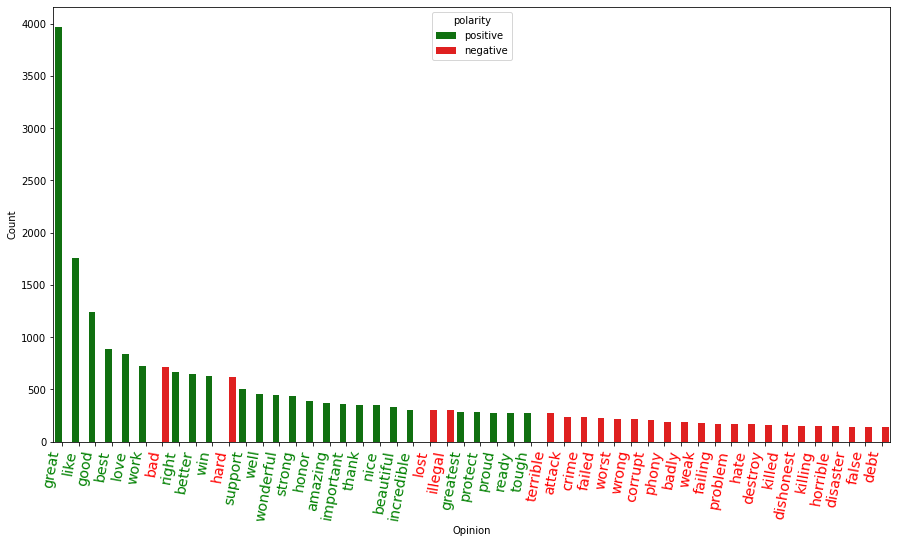

In [ ]:
# call the plot_opinion function to plot our tweets top positives and negatives opinions

plot_opinion(list_top_positives_opinion, list_top_negatives_opinion)


> From the graph, we can hypothesize that the tweets about Trump's communication were extremely positive. More than 4,000 tweets are positive against about 800 tweets that are negative. 
We can conclude that from the tweets in our position, Trump uses positive words in his tweets such as "great", "good", "work", etc. 
Using positive words is an inherent part of Trump's communication and has been for a very long time. It is one of his trademarks. 


---
#### **<font color="pink">  VI. Overall sentiment scores (from positives and negatives words) </span>**


In [ ]:
# Compute the global sentiment score: the total count of positive tweets (e.g. use rdd_positive_tweets_product_count_kv) minus
# the total count of negative tweets (e.g. use rdd_negative_tweets_product_count_kv)


sentiment_score = rdd_positive_tweets_product_count_kv.map(lambda tuple: tuple[1]).sum()\
                  - rdd_negative_tweets_product_count_kv.map(lambda tuple: tuple[1]).sum()

print('The sentiment score is : ',sentiment_score)

The sentiment score is :  11016


The sentiment score is positive, we can conclude that positive words are the most used in Trump's tweets. The use of these positive words is a real asset for the leader, it is part of his communication strategy and also explains his popularity. 

---
### **<font color="pink"> V. Top hashtags (#) cited**

In [ ]:
# - Top hashtags (#) cited
rdd_tweets1 = sc.textFile('drive/MyDrive/Big data tools/Project/trump_tweets.txt')

rdd_tweets1.take(5)

['Republicans and Democrats have both created our economic problems.;02/08/2011 18:07:48',
 'I was thrilled to be back in the Great city of Charlotte, North Carolina with thousands of hardworking American Patriots who love our Country, cherish our values, respect our laws, and always put AMERICA FIRST! Thank you for a wonderful evening!! #KAG2020 https://t.co/dNJZfRsl9y;03/03/2020 01:34:50',
 'RT @CBS_Herridge: READ: Letter to surveillance court obtained by CBS News questions where there will be further disciplinary action and cho…;17/01/2020 03:22:47',
 'The Unsolicited Mail In Ballot Scam is a major threat to our Democracy, &amp  the Democrats know it. Almost all recent elections using this system, even though much smaller &amp   with far fewer Ballots to count, have ended up being a disaster. Large numbers of missing Ballots &amp  Fraud!;12/09/2020 20:10:58',
 "RT @MZHemingway: Very friendly telling of events here about Comey's apparent leaking to compliant media. If you read those 

In [ ]:
# We divide to only have the hastag 
rdd_tweets_clean = rdd_tweets1.flatMap(lambda line: line.split()).filter(lambda word: word.startswith("#")).map(lambda x: x.replace(';', '')).map(lambda x: x.replace('”', '')).map(lambda x: x.replace('’', '')).map(lambda x: x.replace('""""', ''))
rdd_tweets_clean.take(3)

['#KAG2020', '#MAGA', '#VOTE']

In [ ]:
hashtags_count = rdd_tweets_clean.map(lambda word: (word, 1))
hashtags_count.take(5)

[('#KAG2020', 1),
 ('#MAGA', 1),
 ('#VOTE', 1),
 ('#MAGA🇺🇸🦅rally', 1),
 ('#VOTE', 1)]

In [ ]:
hashtags_distinct_count = hashtags_count.reduceByKey(lambda x,y : x+y)
hashtags_distinct_count.take(5)

[('#KAG2020', 61),
 ('#VOTE', 8),
 ('#MAGA🇺🇸🦅rally', 2),
 ('#Election2020', 4),
 ('#…16/10/2020', 1)]

In [ ]:
hashtags_count_ordered = hashtags_distinct_count.sortBy(lambda tuple: tuple[1], ascending=False)
list_top_hashtags = hashtags_count_ordered.take(25)
list_top_hashtags

[('#Trump2016', 455),
 ('#MAGA', 340),
 ('#MakeAmericaGreatAgain', 274),
 ('#1', 109),
 ('#CelebApprentice', 106),
 ('#CelebrityApprentice', 86),
 ('#KAG2020', 61),
 ('#AmericaFirst', 61),
 ('#Trump', 60),
 ('#VoteTrump', 56),
 ('#DrainTheSwamp', 49),
 ('#COVID19', 42),
 ('#ImWithYou', 38),
 ('#BigLeagueTruth', 34),
 ('#TBT', 31),
 ('#USMCA', 30),
 ('#TimeToGetTough', 30),
 ('#FITN', 30),
 ('#CrookedHillary', 29),
 ('#MakeAmericaGreatAgain!', 29),
 ('#trump2016', 27),
 ('#MAGA🇺🇸', 26),
 ('#TrumpTrain', 25),
 ('#DemDebate', 23),
 ('#TRUMP', 23)]

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sb

import pandas as pd

def plot_tweets(list_top_hashtags):
    
    list_1 = [(t[0], t[1], 'hastag') for t in list_top_hashtags]

    pd_df = pd.DataFrame({
     'hastag': [ t[0] for t in list_1 ],
     'Count': [ t[1] for t in list_1 ],}).sort_values('Count', ascending=False)

    plt.figure( figsize = (15, 8) )
    chart=sb.barplot(data=pd_df, x='hastag', y='Count', order=pd_df['hastag'])
    chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=80, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large',
    )
    
    plt.show()

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0, flags=flags)


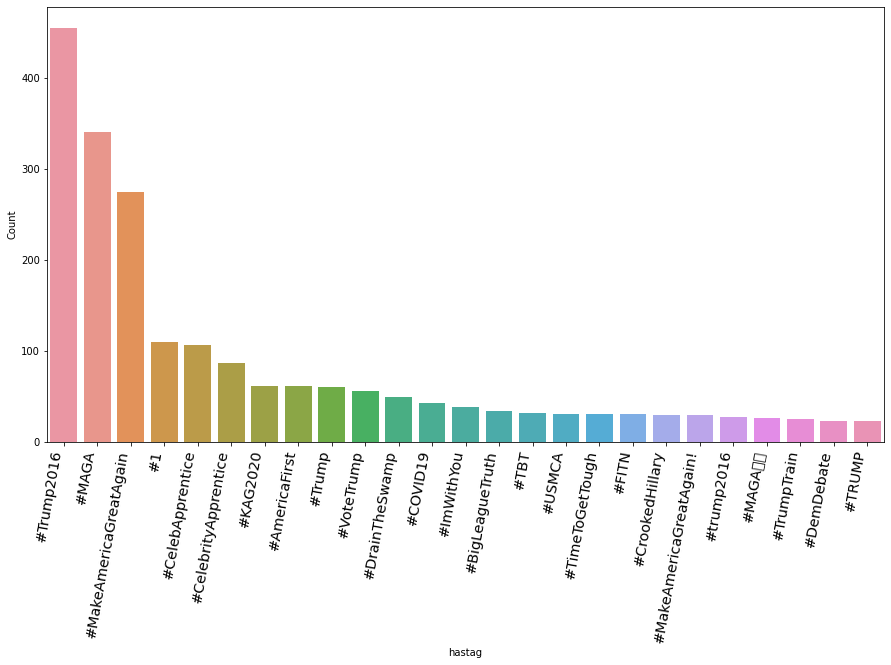

In [ ]:
# call the plot_opinion function to plot our tweets top positives and negatives opinions
plot_tweets(list_top_hashtags)

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import ChainMap
import pyspark.sql.functions as F

def plot_cloud(list_top_hashtags):
    wordcloud = WordCloud(width = 1000, height = 500, random_state=1, background_color='white', colormap='tab20', collocations=False).generate_from_frequencies(dict(list_top_hashtags))
    # Set figure size
    plt.figure(figsize=(15, 10))
    # Display image
    plt.imshow(wordcloud)  
    # No axis details
    plt.axis("off")
    plt.show();


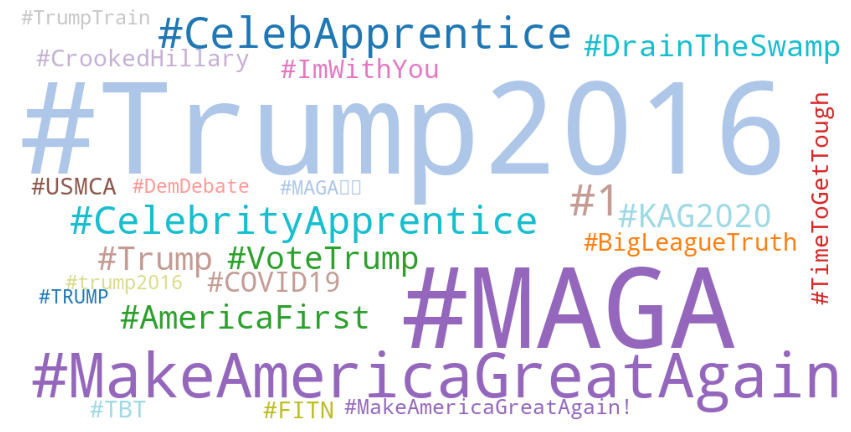

In [ ]:
plot_cloud(list_top_hashtags)

> For a better understanding and analysis, we can use a word cloud and a barplot. In this word cloud, we see that Trump's communication is about his presidency in 2016. His slogan "Make America Great Again" is also used in his communication. The strong presence is often linked to his ideals in order to communicate as much as possible about his position. Trump doesn't hesitate to promote the television programs he has been featured on, like "Celebrity Apprentice," in addition to his ideas.

---
### <font color="pink"> **VI. Top references (@) cited**

In [ ]:
# - Top references (@) cited
at = sc.textFile('drive/MyDrive/Big data tools/Project/trump_tweets.txt').flatMap(lambda line: line.split()).filter(lambda word: word.startswith("@"))

In [ ]:
at_clean = at.flatMap(lambda line: line.split()).filter(lambda word: word.startswith("@")).map(lambda x: x.replace(':', '')).map(lambda x: x.replace(';', '')).map(lambda x: x.replace('”', '')).map(lambda x: x.replace('"', '')).map(lambda x: x.replace('s', '')).map(lambda x: x.replace("'", ""))
at_clean.take(3)

['@CBS_Herridge', '@MZHemingway', '@WhiteHoue']

In [ ]:
at_count = at_clean.map(lambda word: (word, 1))
at_count.take(5)

[('@CBS_Herridge', 1),
 ('@MZHemingway', 1),
 ('@WhiteHoue', 1),
 ('@realDonaldTrump', 1),
 ('@EricTrump', 1)]

In [ ]:
at_distinct_count = at_count.reduceByKey(lambda x,y : x+y)
at_distinct_count.take(5)

[('@CBS_Herridge', 6),
 ('@EricTrump', 172),
 ('@TomFitton', 116),
 ('@marklevinhow', 107),
 ('@realDonaldTrump23/10/2020', 1)]

In [ ]:
at_count_ordered = at_distinct_count.sortBy(lambda tuple: tuple[1], ascending=False)
list_top_at = at_count_ordered.take(25)
list_top_at

[('@realDonaldTrump', 9846),
 ('@WhiteHoue', 755),
 ('@BarackObama', 596),
 ('@FoxNew', 556),
 ('@foxandfriend', 511),
 ('@ApprenticeNBC', 305),
 ('@TeamTrump', 291),
 ('@CNN', 281),
 ('@IvankaTrump', 260),
 ('@eanhannity', 235),
 ('@MittRomney', 226),
 ('@GOP', 221),
 ('@GOPChairwoman', 216),
 ('@DanScavino', 195),
 ('@DonaldJTrumpJr', 193),
 ('@EricTrump', 172),
 ('@Jim_Jordan', 161),
 ('@nytime', 148),
 ('@realDonaldTrump.', 145),
 ('@dbongino', 137),
 ('@GreggJarrett', 134),
 ('@megynkelly', 132),
 ('@FLOTUS', 129),
 ('@POTUS', 117),
 ('@TomFitton', 116)]

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sb

import pandas as pd

def plot_at(list_top_at):
    
    list_1 = [(t[0], t[1], 'hastag') for t in list_top_at]

    pd_df = pd.DataFrame({
     'hastag': [ t[0] for t in list_1 ],
     'Count': [ t[1] for t in list_1 ],}).sort_values('Count', ascending=False)

    plt.figure( figsize = (15, 8) )
    chart=sb.barplot(data=pd_df, x='hastag', y='Count', order=pd_df['hastag'])
    chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=80, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large',
    )
    
    plt.show()

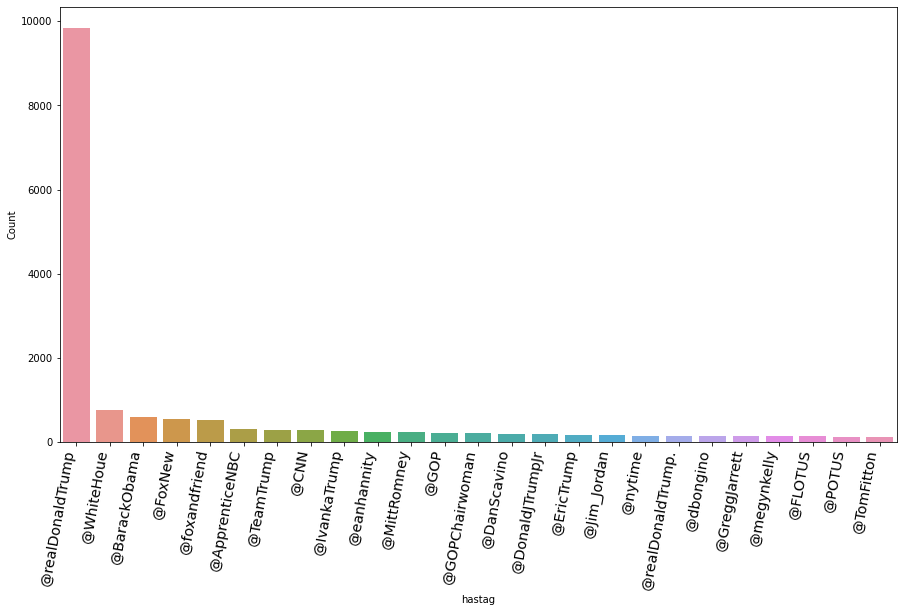

In [ ]:
# call the plot_opinion function to plot our tweets top positives and negatives opinions
plot_at(list_top_at)

> From the data, we may infer that Donald Trump and the House of White were the two most often mentioned entities. These remarks may be explained by the fact that he served as president for four years and that it was a way for him to establish himself. If Barack Obama takes third place, we may assume that it was during the eight-year period of his presidency.
In addition to the fact that Fox News and Trump maintain an alliance, which has benefited Trump during his term as president the references of television are advantageous for him.

---

## <font color="pink"> **VII. Conclusion** </font>

> In conclusion, our charts allow us to draw the conclusion that Trump was quite direct in his communication on social media. He used a lot of positive words in his tweets, and he specifically mentioned his accomplishments on television and his thoughts on Barack Obama's presidency. The hashtags used throughout his campaign were in reference to his motto and the marketing of his campaign.
Trump has been communicating on social media for 11 years in a blunt and direct manner. Currently, we are aware that the communication strategy was effective for a while but quickly failed.
> In fact, as a result of his candidacy, Trump was banned from Twitter in 2021 (a date that is not shown in our database). We may thus conclude that, despite its effectiveness, Trump's communication is not the best in terms of strategy.
---
